Model Training v3 + Optimization

In [12]:
import os
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import optuna
import xgboost as xgb

from sklearn.metrics import (
    roc_auc_score, roc_curve, accuracy_score, precision_score,
    recall_score, f1_score, confusion_matrix, classification_report
)
from sklearn.model_selection import TimeSeriesSplit

# Make sure models folder exists
os.makedirs("../models", exist_ok=True)

# Load v3 short-term engineered features (from Notebook 02 v3)
df = pd.read_csv("../data/processed/qqq_features_v3_5d.csv",
                 index_col="Date", parse_dates=["Date"])

# Define features & target
feature_cols = [c for c in df.columns if c not in ["target", "future_5d_return"]]
X = df[feature_cols]
y = df["target"]

# Time split
train = df.loc["1999":"2018"]
test  = df.loc["2019":]

X_train, y_train = train[feature_cols], train["target"]
X_test,  y_test  = test[feature_cols],  test["target"]

X_train.shape, X_test.shape



((4977, 12), (1724, 12))

Optuna Hyperparameter tunning

In [13]:
tscv = TimeSeriesSplit(n_splits=5)

def objective(trial):
    # Hyperparameters for XGBoost (native API)
    params = {
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "tree_method": "hist",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-3, 10.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-3, 10.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 8),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 0.0, 5.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 0.5, 2.0),
    }

    # Native XGBoost uses num_boost_round (NOT n_estimators)
    num_round = trial.suggest_int("num_boost_round", 100, 800)

    aucs = []

    # Time-series cross validation
    for train_idx, val_idx in tscv.split(X_train):
        X_tr, y_tr = X_train.iloc[train_idx], y_train.iloc[train_idx]
        X_val, y_val = X_train.iloc[val_idx], y_train.iloc[val_idx]

        dtrain = xgb.DMatrix(X_tr, label=y_tr)
        dvalid = xgb.DMatrix(X_val, label=y_val)

        model = xgb.train(
            params,
            dtrain,
            num_boost_round=num_round,
            evals=[(dvalid, "valid")],
            early_stopping_rounds=50,
            verbose_eval=False
        )

        pred_val = model.predict(dvalid)
        auc = roc_auc_score(y_val, pred_val)
        aucs.append(auc)

        trial.report(np.mean(aucs), len(aucs))
        if trial.should_prune():
            raise optuna.TrialPruned()

    return np.mean(aucs)



In [15]:
study = optuna.create_study(
    direction="maximize",
    study_name="qqq_xgb_optuna_v3",
    pruner=optuna.pruners.MedianPruner()
)

study.optimize(objective, n_trials=150, n_jobs=1)

print("Best AUC:", study.best_trial.value)
print("Best Params:")
for k,v in study.best_trial.params.items():
    print(f"{k}: {v}")

# Save study results
study.trials_dataframe().to_csv("../models/optuna_trials_v3.csv", index=False)


[I 2025-11-16 19:25:44,079] A new study created in memory with name: qqq_xgb_optuna_v3
[I 2025-11-16 19:25:45,366] Trial 0 finished with value: 0.5072106308828079 and parameters: {'lambda': 6.8945514638280585, 'alpha': 0.04252219811267577, 'colsample_bytree': 0.677759268087091, 'subsample': 0.6725948650210608, 'learning_rate': 0.014600060221328006, 'max_depth': 7, 'min_child_weight': 2, 'gamma': 1.841477336256709, 'scale_pos_weight': 1.559124927030667, 'num_boost_round': 548}. Best is trial 0 with value: 0.5072106308828079.
[I 2025-11-16 19:25:45,632] Trial 1 finished with value: 0.5154182757084793 and parameters: {'lambda': 0.024089009701521183, 'alpha': 0.14503415932591862, 'colsample_bytree': 0.7868699881201431, 'subsample': 0.8932231251572473, 'learning_rate': 0.14155962478807438, 'max_depth': 2, 'min_child_weight': 5, 'gamma': 4.346949985559769, 'scale_pos_weight': 0.5558963817952995, 'num_boost_round': 497}. Best is trial 1 with value: 0.5154182757084793.
[I 2025-11-16 19:25:46,1

Best AUC: 0.5265784349191442
Best Params:
lambda: 1.40745318666014
alpha: 0.0026444515034188655
colsample_bytree: 0.9188142065854741
subsample: 0.9685115710632336
learning_rate: 0.02275380155474675
max_depth: 2
min_child_weight: 1
gamma: 4.396146630105747
scale_pos_weight: 1.9500085602822161
num_boost_round: 423


Train on full train set with best params

In [16]:
trial = study.best_trial
best_params = trial.params.copy()

best_params.update({
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "tree_method": "hist",
})

# Convert ints
best_params["max_depth"] = int(best_params["max_depth"])
best_params["min_child_weight"] = int(best_params["min_child_weight"])
best_params["num_boost_round"] = int(best_params["num_boost_round"])

# Train using native XGBoost
dtrain_full = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

final_model = xgb.train(
    best_params,
    dtrain_full,
    num_boost_round=best_params["num_boost_round"]
)

pred_prob = final_model.predict(dtest)
pred_label = (pred_prob > 0.5).astype(int)

print("TEST AUC:", roc_auc_score(y_test, pred_prob))
print(classification_report(y_test, pred_label))


TEST AUC: 0.5410181004435994
              precision    recall  f1-score   support

           0       0.64      0.06      0.10       672
           1       0.62      0.98      0.76      1052

    accuracy                           0.62      1724
   macro avg       0.63      0.52      0.43      1724
weighted avg       0.63      0.62      0.50      1724



Diagnostic

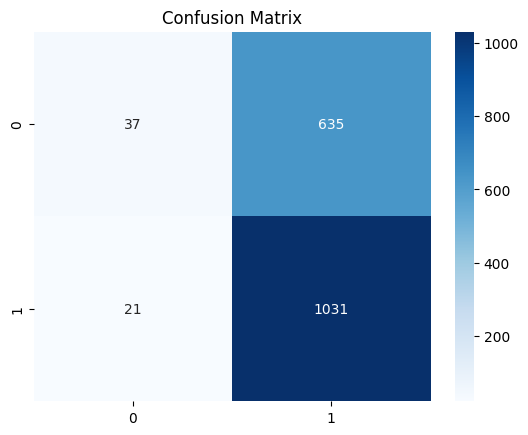

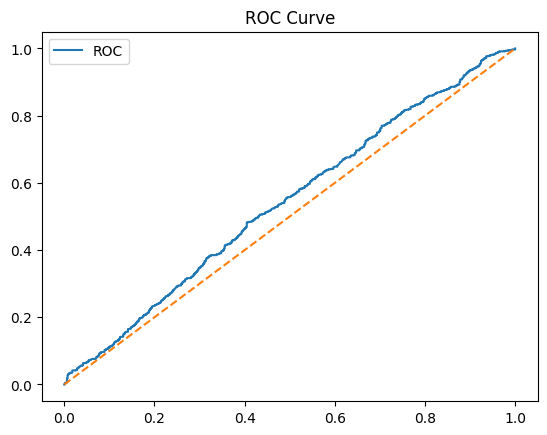

In [17]:
# Confusion matrix
cm = confusion_matrix(y_test, pred_label)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, pred_prob)
plt.plot(fpr, tpr, label="ROC")
plt.plot([0,1],[0,1],"--")
plt.title("ROC Curve")
plt.legend()
plt.show()


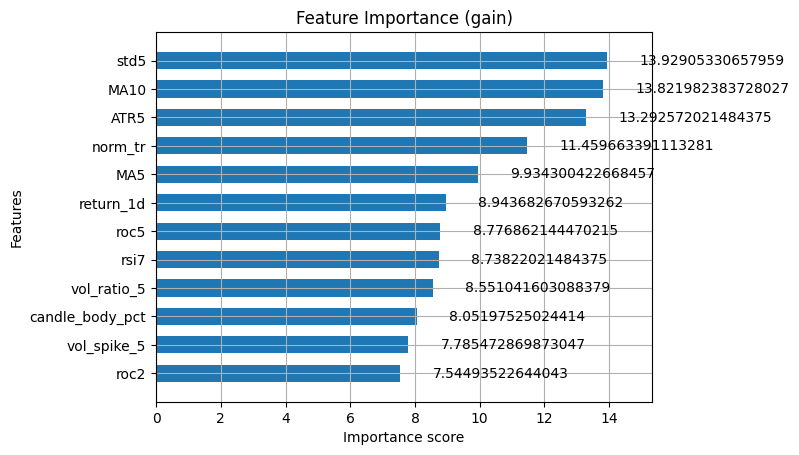

In [18]:
xgb.plot_importance(final_model, importance_type="gain", max_num_features=20, height=0.6)
plt.title("Feature Importance (gain)")
plt.show()


Save model

In [19]:
with open("../models/qqq_xgb_optuna_v3.pkl", "wb") as f:
    pickle.dump(final_model, f)

pred_df = test.copy()
pred_df["pred_prob"] = pred_prob
pred_df["pred_label"] = pred_label
pred_df.to_csv("../data/processed/qqq_predictions_v3_optuna.csv")

print("Saved model + predictions.")


Saved model + predictions.
